In [88]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import random 

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, make_scorer


import xgboost as xgb
from xgboost import XGBRegressor

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

In [23]:
df = pd.read_csv('data/clean/cleaned_parkrun.csv')
df['Date'] = pd.to_datetime(df['Date'])


In [24]:
df.columns

Index(['Date', 'Position', 'Position_score', 'Name', 'Runner_id',
       'Parkrun_count', 'Gender', 'Age_group', 'Time_in_minutes',
       'temperature', 'windspeed', 'precipitation', 'Total_Appearances',
       'Appearance_Instance', 'Days_since_last_parkrun', 'Total_event_runners',
       'PB_mins', 'ave_mins', 'prev_run_time', 'prev_PB',
       'avg_prev_run_times'],
      dtype='object')

In [27]:
# Mapping the 'Age_group' to a numeric value (you could use the starting age of each range)
age_group_map = {
    '18-19': 19,
    '20-24': 22,
    '25-29': 27,
    '30-34': 32,
    '35-39': 37,
    '40-44': 42,
    '45-49': 47,
    '50-54': 52,
    '55-59': 57,
    '60-64': 62,
    '65-69': 67,
    '70-74': 72
}

# Apply the mapping to the 'Age_group' column
df['Age_group_numeric'] = df['Age_group'].map(age_group_map)

In [29]:
df['first_parkrun_date'] = df.groupby('Runner_id')['Date'].transform('min')
df['Days_since_first_parkrun'] = (df['Date'] - df['first_parkrun_date']).dt.days

In [31]:
df['Male'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

In [33]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157970 entries, 0 to 157969
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Date                      157970 non-null  datetime64[ns]
 1   Position                  157970 non-null  int64         
 2   Position_score            157970 non-null  float64       
 3   Name                      157970 non-null  object        
 4   Runner_id                 157970 non-null  int64         
 5   Parkrun_count             157970 non-null  int64         
 6   Gender                    157970 non-null  object        
 7   Age_group                 157970 non-null  object        
 8   Time_in_minutes           157970 non-null  float64       
 9   temperature               157970 non-null  float64       
 10  windspeed                 157970 non-null  float64       
 11  precipitation             157970 non-null  float64       
 12  To

In [35]:
df.columns

Index(['Date', 'Position', 'Position_score', 'Name', 'Runner_id',
       'Parkrun_count', 'Gender', 'Age_group', 'Time_in_minutes',
       'temperature', 'windspeed', 'precipitation', 'Total_Appearances',
       'Appearance_Instance', 'Days_since_last_parkrun', 'Total_event_runners',
       'PB_mins', 'ave_mins', 'prev_run_time', 'prev_PB', 'avg_prev_run_times',
       'Age_group_numeric', 'first_parkrun_date', 'Days_since_first_parkrun',
       'Male'],
      dtype='object')

In [37]:
# Drop the target and non-numeric columns
X = df.drop(columns=['Date', 'Position', 'Position_score', 'Name', 'Runner_id',
       'Parkrun_count', 'Gender', 'Age_group', 'Time_in_minutes',
       'Total_Appearances', 'PB_mins', 'ave_mins',
       'first_parkrun_date'])
y = df['Time_in_minutes']


In [41]:
# Step 1: Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Step 2: Initialize MinMaxScaler
scaler = MinMaxScaler()

# Step 3: Normalize the training data
X_train_norm = scaler.fit_transform(X_train)

# Optionally, you can also scale the test data using the same scaler
X_test_norm = scaler.transform(X_test)

# Convert the normalized data back to DataFrame
X_train_norm_df = pd.DataFrame(X_train_norm, columns=X.columns)
X_test_norm_df = pd.DataFrame(X_test_norm, columns=X.columns)

In [90]:
def plot_feature_importance(model, feature_names, title):
    """
    Function to plot feature importance of a trained model.
    
    Parameters:
    model: Trained model (e.g., RandomForestRegressor)
    feature_names: List of feature names
    
    Returns:
    feature_importances
    """
    feature_importances = model.feature_importances_
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, feature_importances)  # Horizontal bar plot for better readability
    plt.xlabel('Feature Importance')
    plt.title(f'{title} Feature Importances')
    plt.show()
    return feature_importances

def plot_predicted_vs_actual(y_test, y_pred, title):
    """
    Function to plot scatter plot of predicted vs actual values.
    
    Parameters:
    y_test: Actual target values
    y_pred: Predicted target values
    
    Returns:
    None
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Line for perfect prediction
    
    plt.xlabel('Actual Run Time (minutes)')
    plt.ylabel('Predicted Run Time (minutes)')
    plt.title(f'{title} Scatter Plot: Predicted vs Actual Run Time')
    plt.show()

Root Mean Squared Error: 2.277
R-squared: 0.82


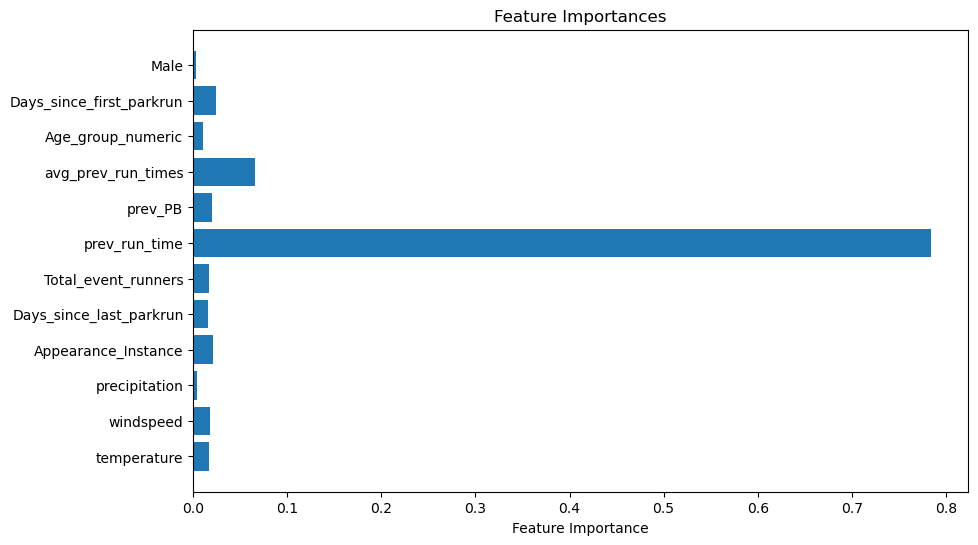

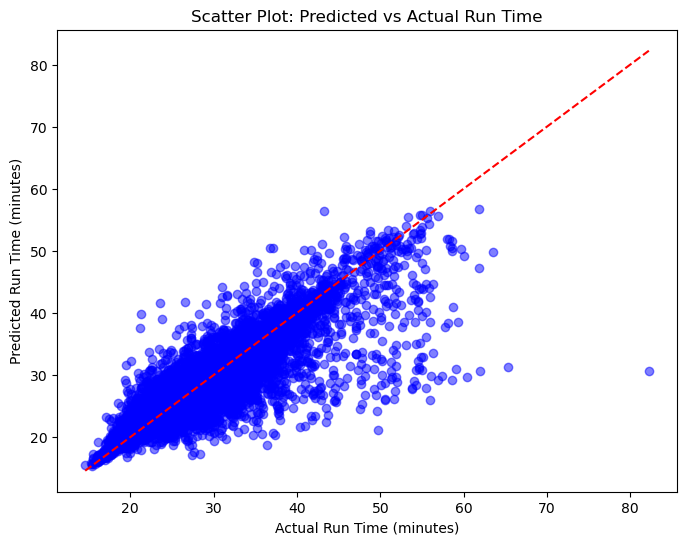

In [45]:
# Initialize and train Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train_norm_df, y_train)

# Predict on test set
y_pred_rf = rf.predict(X_test_norm_df)

# Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(f'Root Mean Squared Error: {rmse.round(3)}')
print(f'R-squared: {r2.round(3)}')

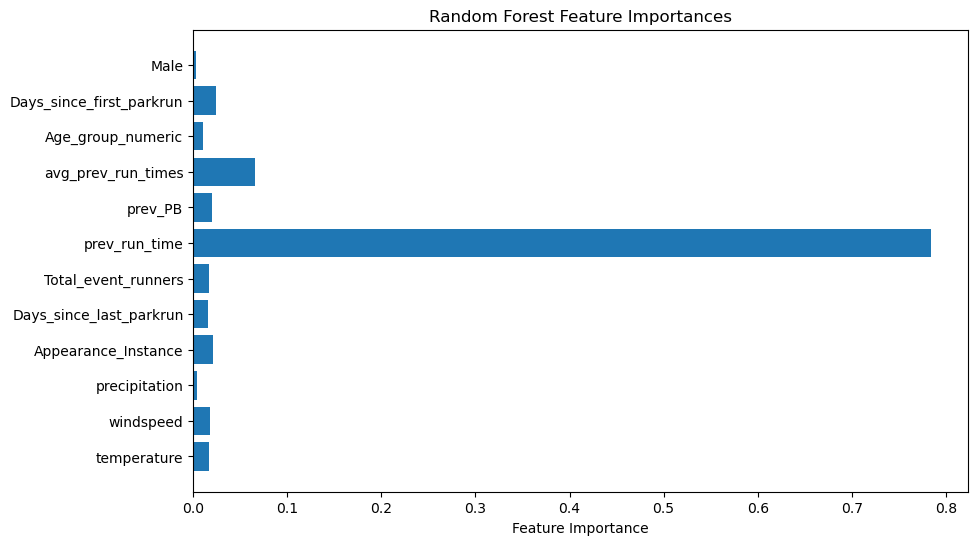

<Figure size 640x480 with 0 Axes>

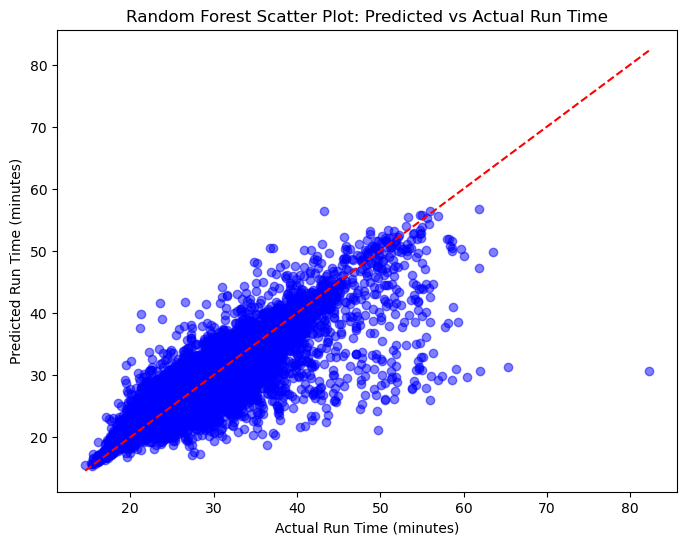

In [106]:
# Call functions to visualize feature importance and predicted vs actual
rf_features = plot_feature_importance(rf, X_train_norm_df.columns, 'Random Forest')
plot_predicted_vs_actual(y_test, y_pred_rf, 'Random Forest')

Linear Regression - RMSE: 2.379
Linear Regression - R-squared: 0.803


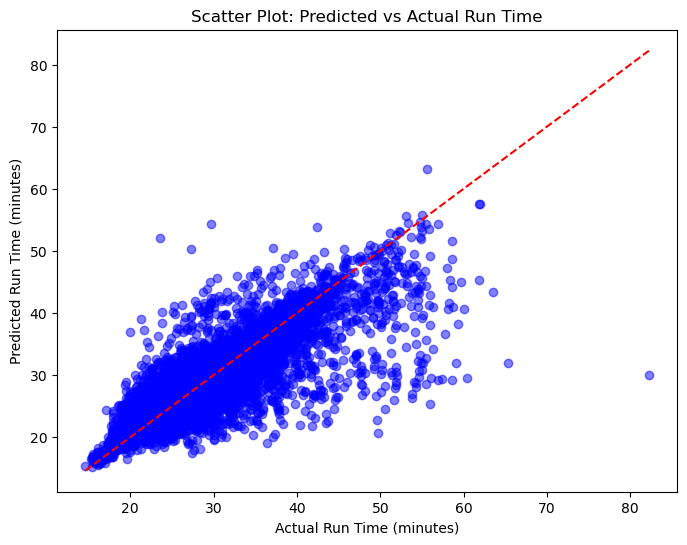

In [46]:
# Initialize and train Linear Regression model
lr = LinearRegression()
lr.fit(X_train_norm_df, y_train)

# Predict on test set
y_pred_lr = lr.predict(X_test_norm_df)

# Evaluate the model
rmse_lr = root_mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f'Linear Regression - RMSE: {rmse_lr.round(3)}')
print(f'Linear Regression - R-squared: {r2_lr.round(3)}')


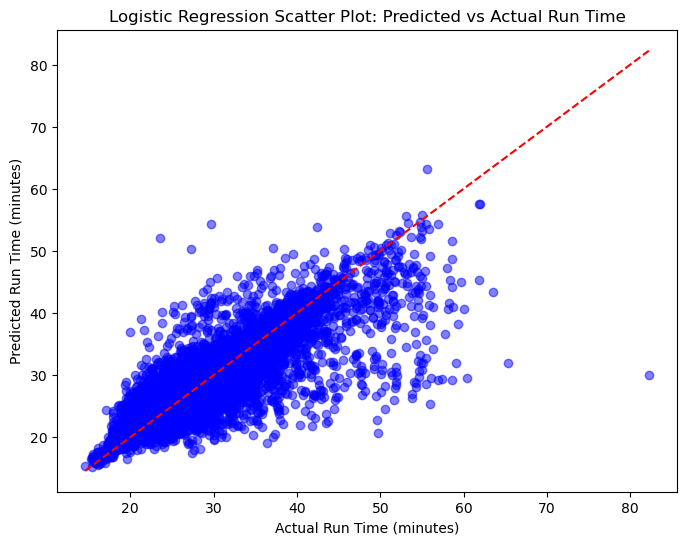

In [108]:
# Visualize results
plot_predicted_vs_actual(y_test, y_pred_lr, 'Logistic Regression')

Gradient Boosting - RMSE: 2.296
Gradient Boosting - R-squared: 0.817


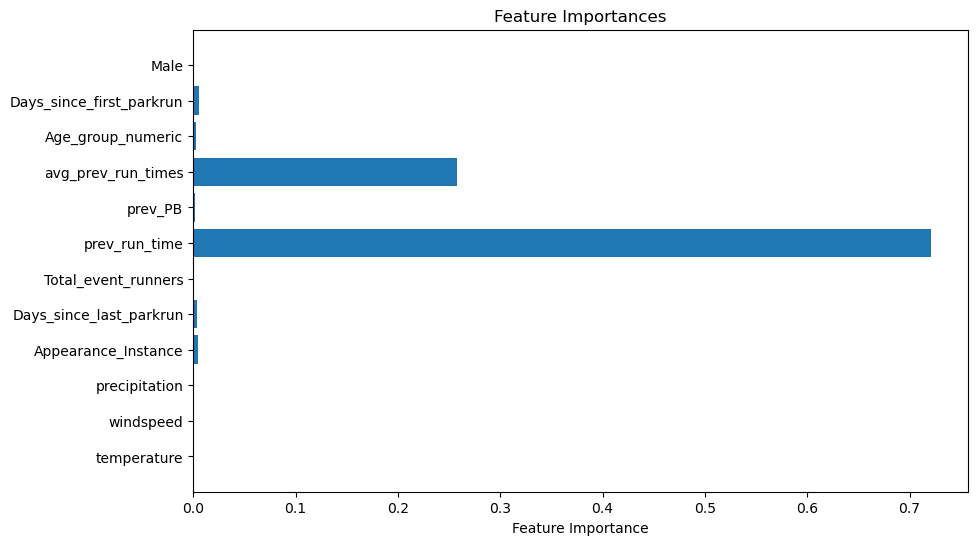

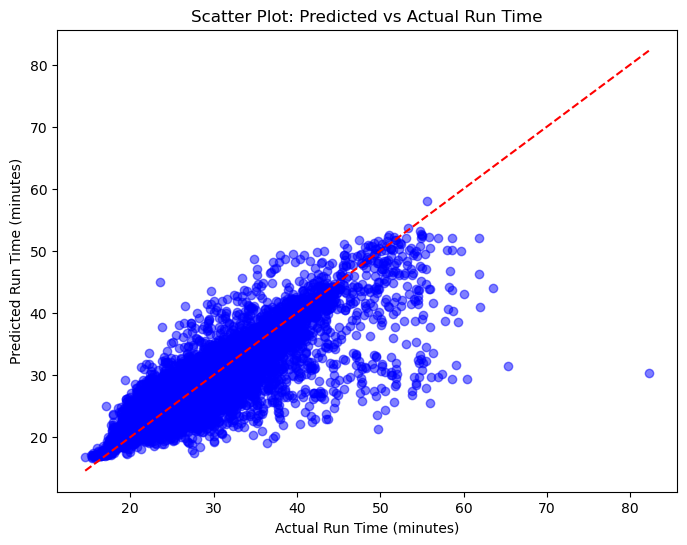

In [47]:
# Initialize and train Gradient Boosting model
gb = GradientBoostingRegressor(n_estimators=100, random_state=0)
gb.fit(X_train_norm_df, y_train)

# Predict on test set
y_pred_gb = gb.predict(X_test_norm_df)

# Evaluate the model
rmse_gb = root_mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f'Gradient Boosting - RMSE: {rmse_gb.round(3)}')
print(f'Gradient Boosting - R-squared: {r2_gb.round(3)}')


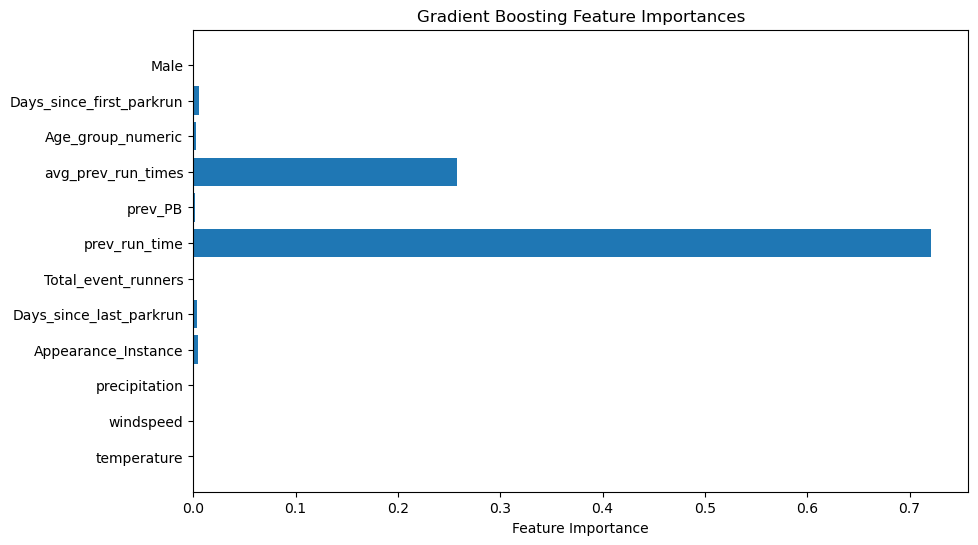

<Figure size 640x480 with 0 Axes>

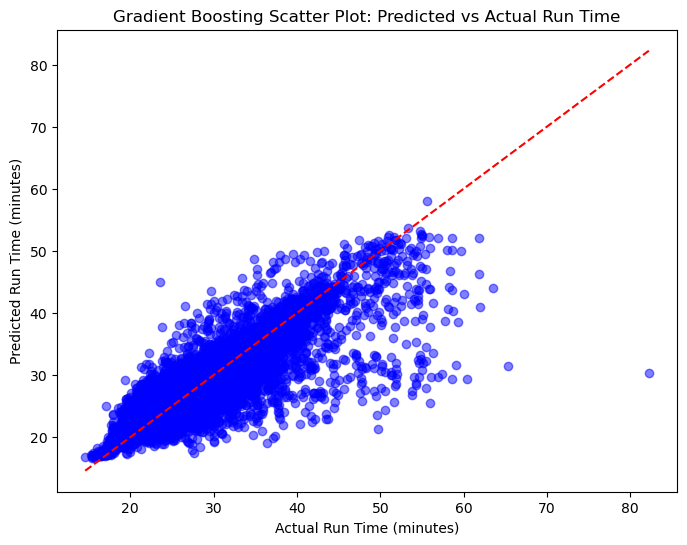

In [110]:
# Visualize results
gb_features = plot_feature_importance(gb, X_train_norm_df.columns, 'Gradient Boosting')
plot_predicted_vs_actual(y_test, y_pred_gb, 'Gradient Boosting')

XGBoost - RMSE: 2.263
XGBoost - R-squared: 0.822


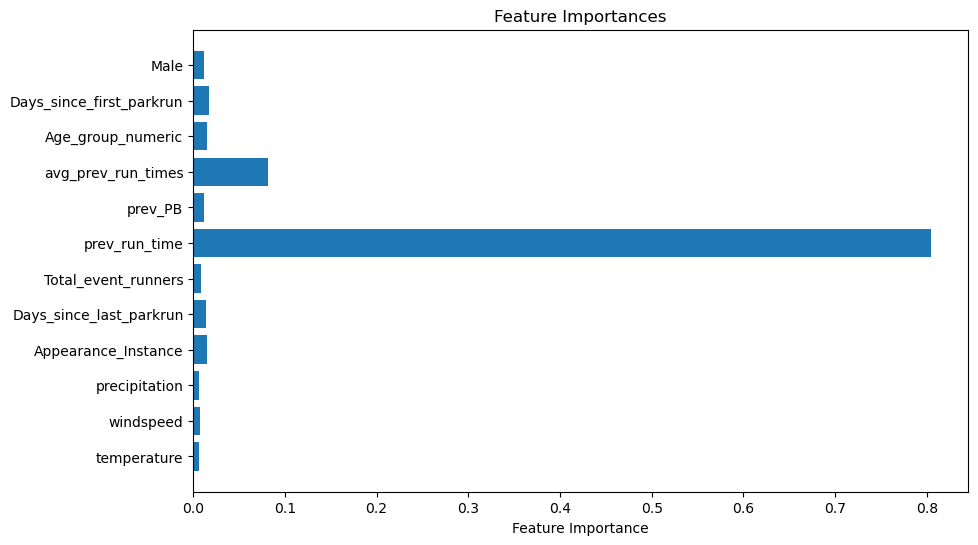

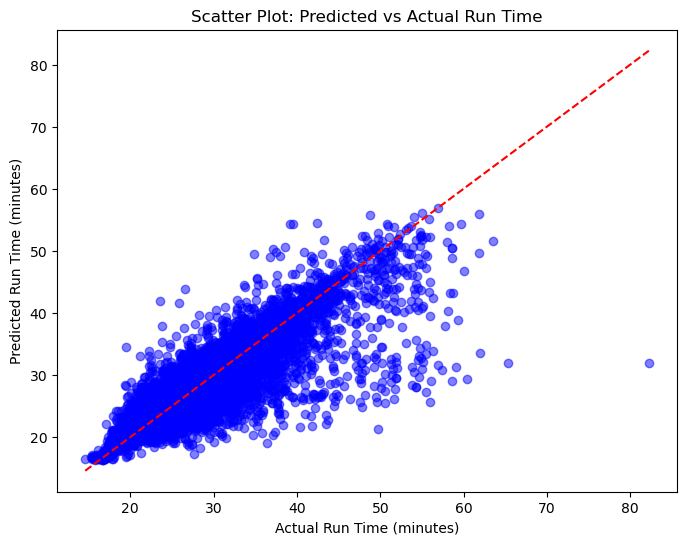

In [48]:
# Initialize and train XGBoost model
xg = xgb.XGBRegressor(n_estimators=100, random_state=0)
xg.fit(X_train_norm_df, y_train)

# Predict on test set
y_pred_xg = xg.predict(X_test_norm_df)

# Evaluate the model
rmse_xg = root_mean_squared_error(y_test, y_pred_xg)
r2_xg = r2_score(y_test, y_pred_xg)

print(f'XGBoost - RMSE: {rmse_xg.round(3)}')
print(f'XGBoost - R-squared: {r2_xg.round(3)}')


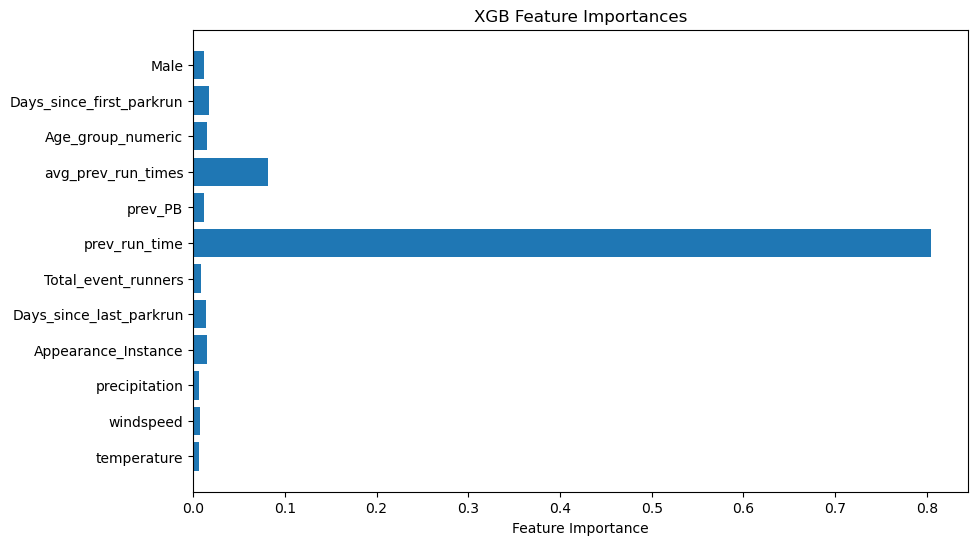

<Figure size 640x480 with 0 Axes>

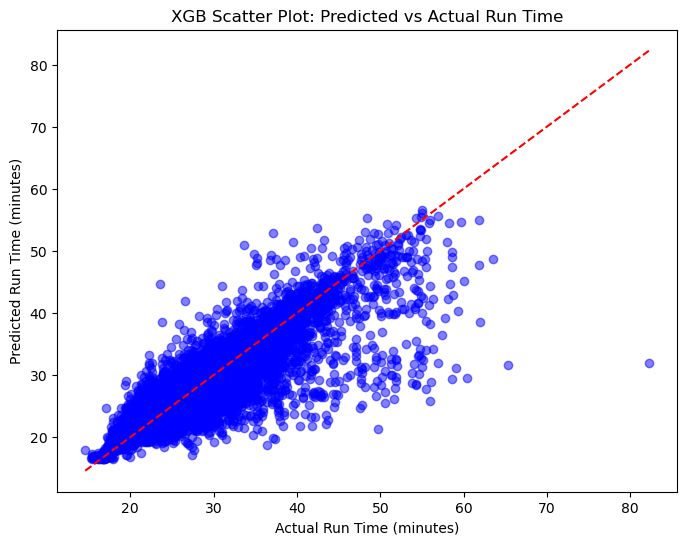

In [112]:
# Visualize results
xg_features = plot_feature_importance(xg, X_train_norm_df.columns, 'XGB')
plot_predicted_vs_actual(y_test, y_pred_xg, 'XGB')

Support Vector Regression - RMSE: 2.38
Support Vector Regression - R-squared: 0.803


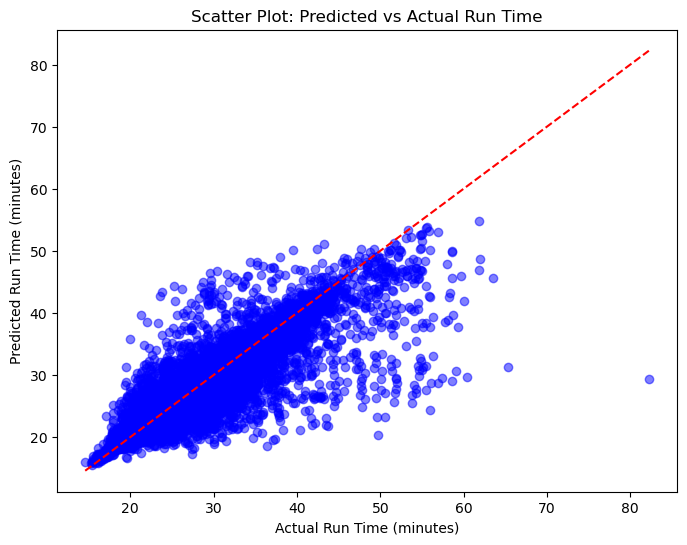

In [49]:
# Initialize and train SVR model
svr = SVR(kernel='rbf')
svr.fit(X_train_norm_df, y_train)

# Predict on test set
y_pred_svr = svr.predict(X_test_norm_df)

# Evaluate the model
rmse_svr = root_mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f'Support Vector Regression - RMSE: {rmse_svr.round(3)}')
print(f'Support Vector Regression - R-squared: {r2_svr.round(3)}')


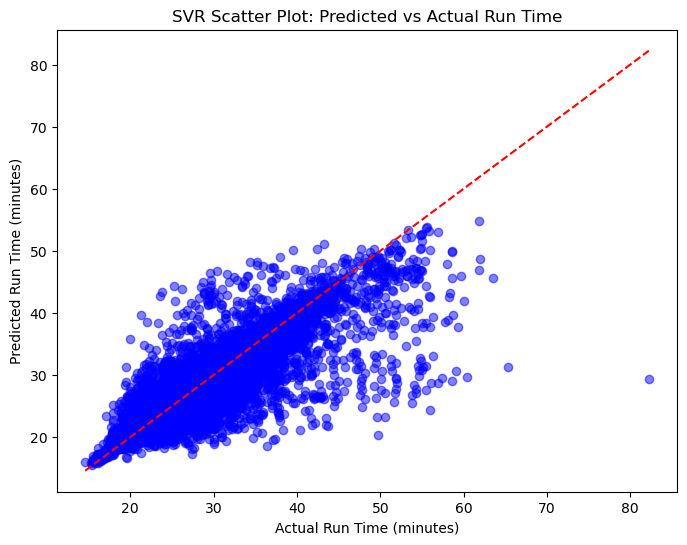

In [114]:
# Visualize results
plot_predicted_vs_actual(y_test, y_pred_svr, 'SVR')

KNN - RMSE: 2.606
KNN - R-squared: 0.764


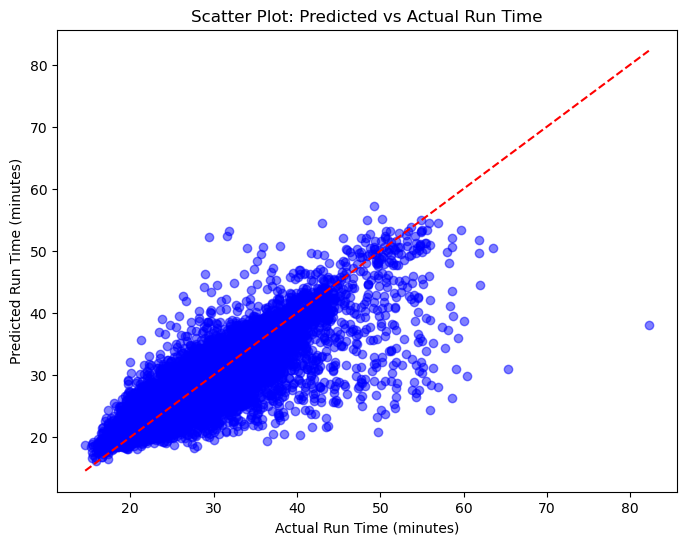

In [50]:
# Initialize and train KNN model
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_norm_df, y_train)

# Predict on test set
y_pred_knn = knn.predict(X_test_norm_df)

# Evaluate the model
rmse_knn = root_mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f'KNN - RMSE: {rmse_knn.round(3)}')
print(f'KNN - R-squared: {r2_knn.round(3)}')


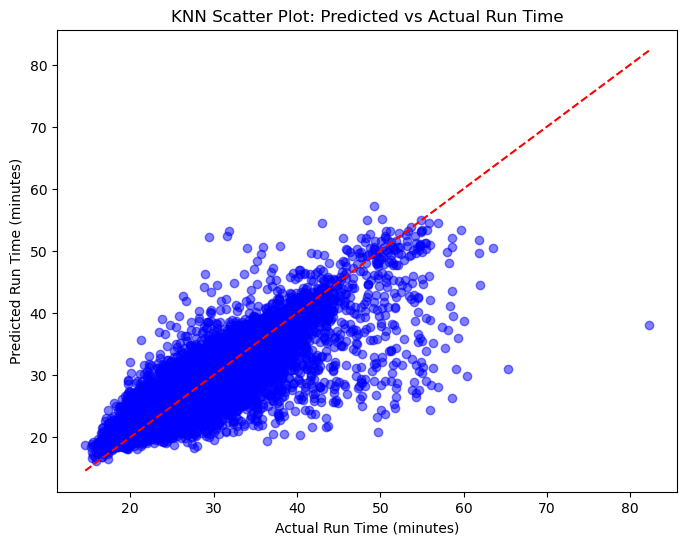

In [116]:
# Visualize results
plot_predicted_vs_actual(y_test, y_pred_knn, 'KNN')

In [51]:
print(f'KNN - RMSE: {rmse_knn.round(3)}')
print(f'KNN - R-squared: {r2_knn.round(3)}')
print(f'Support Vector Regression - RMSE: {rmse_svr.round(3)}')
print(f'Support Vector Regression - R-squared: {r2_svr.round(3)}')
print(f'XGBoost - RMSE: {rmse_xg.round(3)}')
print(f'XGBoost - R-squared: {r2_xg.round(3)}')
print(f'Gradient Boosting - RMSE: {rmse_gb.round(3)}')
print(f'Gradient Boosting - R-squared: {r2_gb.round(3)}')
print(f'Linear Regression - RMSE: {rmse_lr.round(3)}')
print(f'Linear Regression - R-squared: {r2_lr.round(3)}')
print(f'Random Forest - RMSE: {rmse.round(3)}')
print(f'Random Forest - R-squared: {r2.round(3)}')

KNN - RMSE: 2.606
KNN - R-squared: 0.764
Support Vector Regression - RMSE: 2.38
Support Vector Regression - R-squared: 0.803
XGBoost - RMSE: 2.263
XGBoost - R-squared: 0.822
Gradient Boosting - RMSE: 2.296
Gradient Boosting - R-squared: 0.817
Linear Regression - RMSE: 2.379
Linear Regression - R-squared: 0.803
Random Forest - RMSE: 2.277
Random Forest - R-squared: 0.82


In [52]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBRegressor(random_state=0)
grid_search = GridSearchCV(estimator=xgb, param_grid=params, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train_norm_df, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}


Test RMSE: 2.241
Test R-squared: 0.825


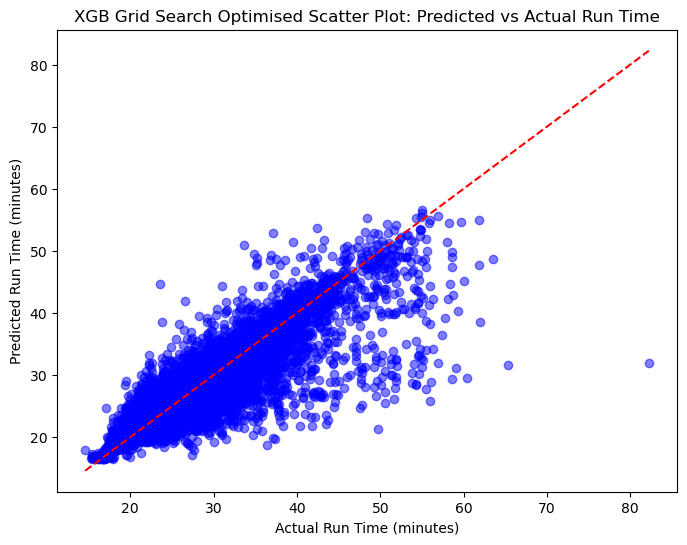

In [120]:
#colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0

# Retrieve the best parameters
best_params = grid_search.best_params_

# Train the model with the best parameters
best_model = XGBRegressor(**best_params, random_state=0)
best_model.fit(X_train_norm_df, y_train)

# Predict on the test set
y_pred_xg_grid = best_model.predict(X_test_norm_df)

# Evaluate the model
rmse_xg = root_mean_squared_error(y_test, y_pred_xg_grid)
r2_xg = r2_score(y_test, y_pred_xg_grid)

print(f"Test RMSE: {rmse_xg:.3f}")
print(f"Test R-squared: {r2_xg:.3f}")

plot_predicted_vs_actual(y_test, y_pred_xg_grid, 'XGB Grid Search Optimised')

In [79]:
def objective(trial):
    # Define hyperparameter space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    }

    # Create and evaluate the model
    model = XGBRegressor(**params, random_state=0)
    scores = cross_val_score(model, X_train_norm_df, y_train, 
                             cv=5, scoring=make_scorer(r2_score, greater_is_better=True))
    
    return np.mean(scores)

In [81]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=80)  # Adjust n_trials as needed

# Best parameters and score
print("Best Parameters:", study.best_params)
print("Best R2:", study.best_value)

[I 2024-12-11 20:07:00,562] A new study created in memory with name: no-name-9ca0cba9-f72a-4c3d-879a-3ebb0afb7f2d
[I 2024-12-11 20:07:06,006] Trial 0 finished with value: 0.8254833459138788 and parameters: {'n_estimators': 112, 'max_depth': 10, 'learning_rate': 0.10371899197781333, 'subsample': 0.7251953791652996, 'colsample_bytree': 0.974246829332585, 'gamma': 1.785686063820452, 'reg_alpha': 7.3721634144331585, 'reg_lambda': 4.559672917543995}. Best is trial 0 with value: 0.8254833459138788.
[I 2024-12-11 20:07:11,320] Trial 1 finished with value: 0.8243274225056038 and parameters: {'n_estimators': 209, 'max_depth': 8, 'learning_rate': 0.13425301801282152, 'subsample': 0.7256216500764329, 'colsample_bytree': 0.8271254151724705, 'gamma': 2.4978126289093328, 'reg_alpha': 7.3730067680743225, 'reg_lambda': 4.341776680307467}. Best is trial 0 with value: 0.8254833459138788.
[I 2024-12-11 20:07:23,362] Trial 2 finished with value: 0.8253826359786671 and parameters: {'n_estimators': 243, 'ma

Best Parameters: {'n_estimators': 296, 'max_depth': 10, 'learning_rate': 0.02241158880126037, 'subsample': 0.9168402757869343, 'colsample_bytree': 0.7264501699168868, 'gamma': 2.2654921340702168, 'reg_alpha': 7.668318887440582, 'reg_lambda': 4.024957630833628}
Best R2: 0.8284893657351973


In [82]:
# Train final model with best parameters
best_params = study.best_params
best_model = XGBRegressor(**best_params, random_state=0)
best_model.fit(X_train_norm_df, y_train)

# Evaluate on test data
y_pred_opt_test = best_model.predict(X_test_norm_df)
rmse_opt_test = root_mean_squared_error(y_test, y_pred_opt_test)
r2_opt_test = r2_score(y_test, y_pred_opt_test)

# Evaluate on training data
y_pred_opt_train = best_model.predict(X_train_norm_df)
rmse_opt_train = root_mean_squared_error(y_train, y_pred_opt_train)
r2_opt_train = r2_score(y_train, y_pred_opt_train)

# Print results
print(f"Training RMSE: {rmse_opt_train:.3f}")
print(f"Training R-squared: {r2_opt_train:.3f}")
print("")
print(f"Test RMSE: {rmse_opt_test:.3f}")
print(f"Test R-squared: {r2_opt_test:.3f}")

Training RMSE: 1.844
Training R-squared: 0.886

Test RMSE: 2.217
Test R-squared: 0.829


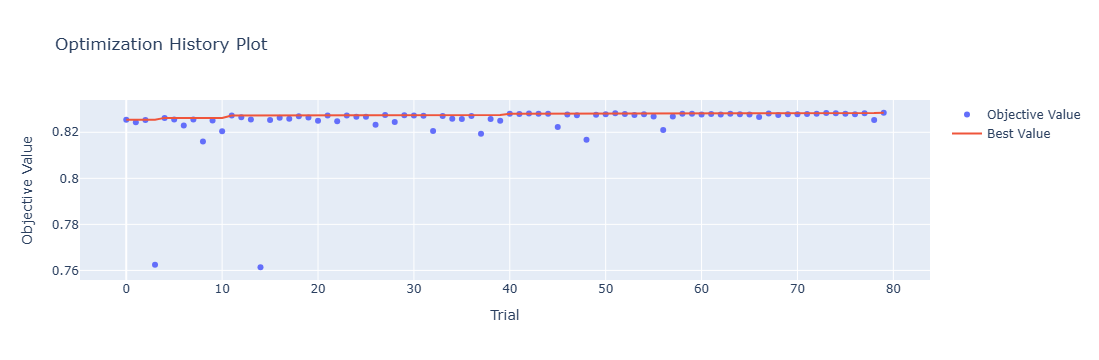

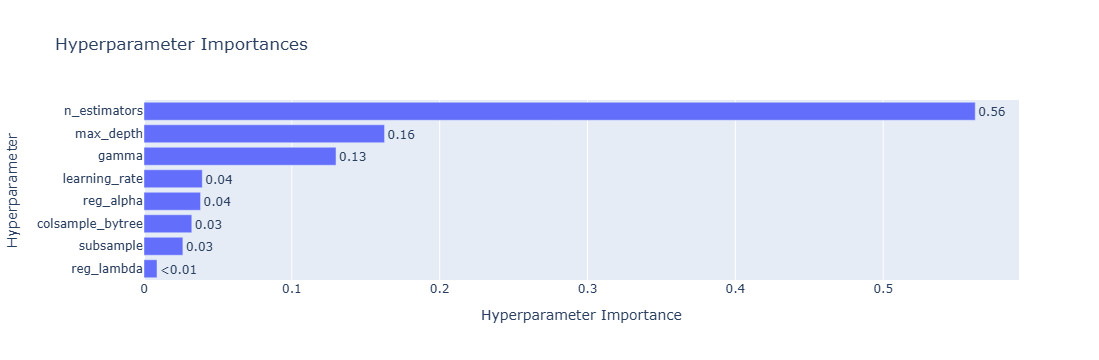

In [83]:
plot_optimization_history(study).show()
plot_param_importances(study).show()

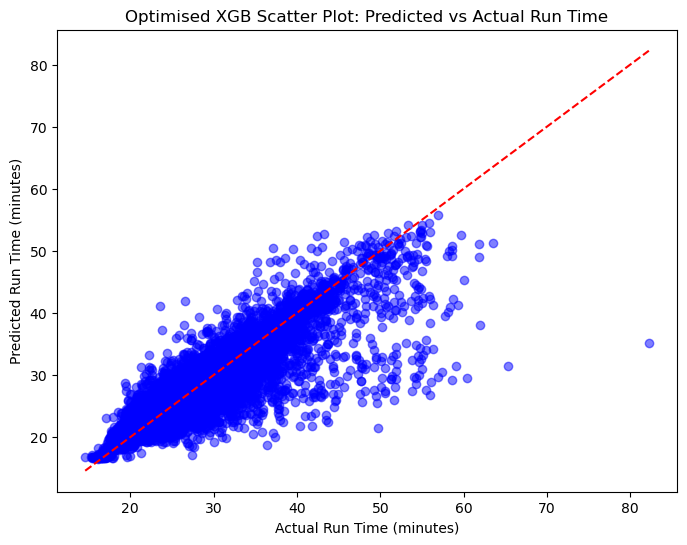

In [104]:
plot_predicted_vs_actual(y_test, y_pred_opt_test, 'Optimised XGB')